# **Store Sales - Time Series Forecasting**

Perusahaan retailer grosir asal Ecuador, Corporación Favorita merupakan perusahaan yang telah berdiri sejak 1952. Perusahaan ini telah memiliki 54 toko cabang dan 33 produk yang terangkum dalam data. Adapun data ini berbentuk time series yang dimulai dari 01 Januari 2013 hingga 15 Agustus 2017.

Untuk mengoptimalkan penjualan pada Corporación Favorita,
Data Scientist ditugaskan memprediksi penjualan untuk setiap
kelompok produk dan kombinasi toko selama 15 hari kedepan (2017-08-16 hingga 2017-08-30)

# **Libraries**

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import  HistGradientBoostingRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from pmdarima.arima import auto_arima
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# **Importing Data**

In [ ]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
df_holiday = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
df_sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'], index_col=False)
df_test.drop(columns='id', inplace=True)
df_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',parse_dates=['date'], index_col=False)
df_train.drop(columns='id', inplace=True)
df_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])

# **EDA**

## **Train Data**

In [ ]:
display(df_train)
display(df_train.info())

date  store_nbr                      family     sales   
0       2013-01-01          1                  AUTOMOTIVE     0.000  \
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3000888 entries, 0 to 3000887

Data columns (total 5 columns):

 #   Column       Dtype         

---  ------       -----         

 0   date         datetime64[ns]

 1   store_nbr    int64         

 2   family       object        

 3   sales        float64       

 4   onpromotion  int64         

dtypes: datetime64[ns](1), float64(1), int64(2), object(1)

memory usage: 114.5+ MB


None

**Data terdiri dari beberapa kombinasi penjualan [family] (produk) di tiap toko [store_nbr].**

In [ ]:
#Mencari jenis-jenis produk dan toko
cols = ['store_nbr', 'family']
for i in cols:
    print(f'Jumlah jenis {i}: {len(df_train[i].unique())}')
    print(f'Jenis {i}: {df_train[i].unique()}')

Jumlah jenis store_nbr: 54

Jenis store_nbr: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30

 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52

 53 54  6  7  8  9]

Jumlah jenis family: 33

Jenis family: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'

 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'

 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'

 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'

 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'

 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'

 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [ ]:
df_train[df_train.isnull().any(axis=1)] # Tidak ada null value

Empty DataFrame
Columns: [date, store_nbr, family, sales, onpromotion]
Index: []

## **Test Data**

In [ ]:
display(df_test)
display(df_test.info())

date  store_nbr                      family  onpromotion
0     2017-08-16          1                  AUTOMOTIVE            0
1     2017-08-16          1                   BABY CARE            0
2     2017-08-16          1                      BEAUTY            2
3     2017-08-16          1                   BEVERAGES           20
4     2017-08-16          1                       BOOKS            0
...          ...        ...                         ...          ...
28507 2017-08-31          9                     POULTRY            1
28508 2017-08-31          9              PREPARED FOODS            0
28509 2017-08-31          9                     PRODUCE            1
28510 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511 2017-08-31          9                     SEAFOOD            0

[28512 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 28512 entries, 0 to 28511

Data columns (total 4 columns):

 #   Column       Non-Null Count  Dtype         

---  ------       --------------  -----         

 0   date         28512 non-null  datetime64[ns]

 1   store_nbr    28512 non-null  int64         

 2   family       28512 non-null  object        

 3   onpromotion  28512 non-null  int64         

dtypes: datetime64[ns](1), int64(2), object(1)

memory usage: 891.1+ KB


None

In [ ]:
#Mencari jenis-jenis produk dan toko
cols = ['store_nbr', 'family']
for i in cols:
    print(f'Jumlah jenis {i}: {len(df_test[i].unique())}')
    print(f'Jenis {i}: {df_test[i].unique()}')

Jumlah jenis store_nbr: 54

Jenis store_nbr: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30

 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52

 53 54  6  7  8  9]

Jumlah jenis family: 33

Jenis family: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'

 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'

 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'

 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'

 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'

 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'

 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [ ]:
df_test[df_test.isnull().any(axis=1)] # Tidak ada null value

Empty DataFrame
Columns: [date, store_nbr, family, onpromotion]
Index: []

## **Seasonality**

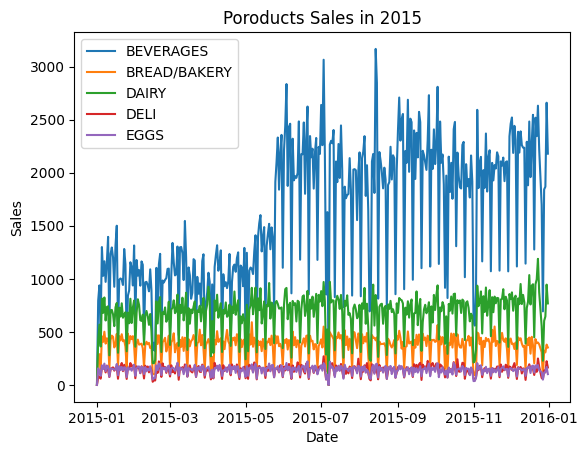

In [ ]:
#Plot penjulan
#Contoh menggunakan store 1 dan 5 produk di tahun 2015
start_date = '2015-01-01'
end_date = '2015-12-31'

store_sales = df_train[(df_train['store_nbr'] == 1) & 
                       (df_train['date'].between(start_date, end_date))]
store_sales = store_sales[['date','sales','family']]
#store_sales['date'] = store_sales.date.dt.to_period('D')

daily_sales = store_sales.groupby(['date','family'], as_index=False).sum()
cols = ['BEVERAGES','BREAD/BAKERY','DAIRY','DELI','EGGS']
for i in cols:
    fam_sales = daily_sales[daily_sales['family'] == i]
    fam_sales = fam_sales[['date','sales']]
    fam_sales = fam_sales.set_index('date')
    plt.plot(fam_sales.index, fam_sales['sales'], label=i)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Poroducts Sales in 2015')
plt.legend()
plt.show()

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

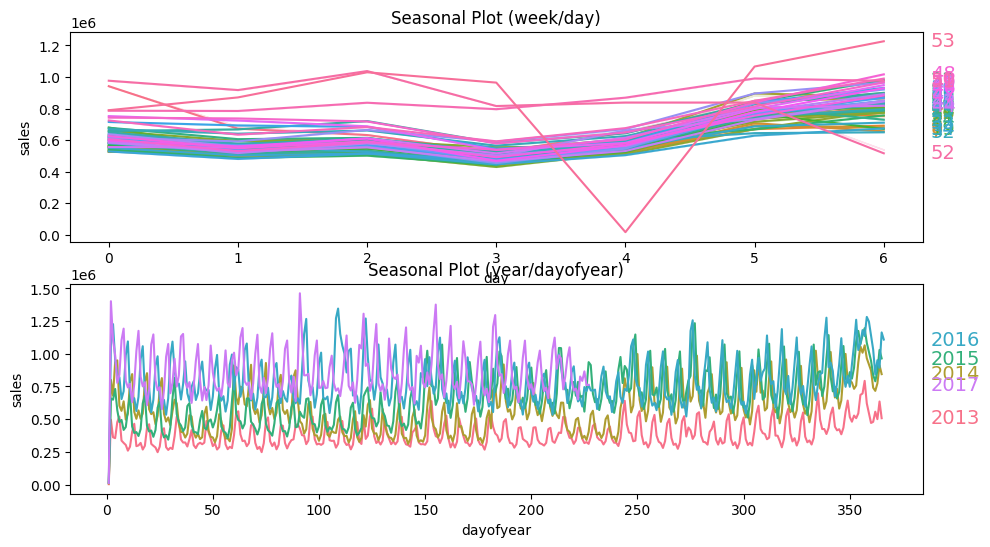

In [ ]:
cols = ['store_nbr','family','onpromotion'] 
#cols = ['date','sales'] 
store_sales = df_train.copy()
store_sales = store_sales.drop(columns=cols)
store_sales['date'] = store_sales.date.dt.to_period('D')

day_sales = store_sales.groupby(['date']).sum()

X = day_sales.copy()

# days within a week
X["day"] = X.index.dayofweek 
X["week"] = X.index.week  

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

In [ ]:
day_sales

sales
date                     
2013-01-01    2511.618999
2013-01-02  496092.417944
2013-01-03  361461.231124
2013-01-04  354459.677093
2013-01-05  477350.121229
...                   ...
2017-08-11  826373.722022
2017-08-12  792630.535079
2017-08-13  865639.677471
2017-08-14  760922.406081
2017-08-15  762661.935939

[1684 rows x 1 columns]

In [ ]:
day_sales

sales
date                     
2013-01-01    2511.618999
2013-01-02  496092.417944
2013-01-03  361461.231124
2013-01-04  354459.677093
2013-01-05  477350.121229
...                   ...
2017-08-11  826373.722022
2017-08-12  792630.535079
2017-08-13  865639.677471
2017-08-14  760922.406081
2017-08-15  762661.935939

[1684 rows x 1 columns]

## **Anomaly**
Terjadi gempa di Ecuador pada 16 April 2016

In [ ]:
start_2016 = '2016-03-01'
end_2016 = '2016-05-15'

gempa_df = df_train[(df_train['store_nbr'] == 1) & 
                   (df_train['date'].between(start_2016,end_2016))]
gempa_df = gempa_df.drop(columns=['onpromotion','family','store_nbr'])
gempa_df = gempa_df.groupby('date', as_index=False).sum()
gempa_df

date         sales
0  2016-03-01  11442.525000
1  2016-03-02  14227.763700
2  2016-03-03   9907.659000
3  2016-03-04  13024.526080
4  2016-03-05  12215.610000
..        ...           ...
71 2016-05-11  13033.325999
72 2016-05-12   9427.574999
73 2016-05-13  11462.110995
74 2016-05-14  11160.272000
75 2016-05-15   5386.157000

[76 rows x 2 columns]

In [ ]:
start_2015 = '2015-03-01'
end_2015 = '2015-05-15'

nogempa_df = df_train[(df_train['store_nbr'] == 1) & 
                   (df_train['date'].between(start_2015,end_2015))]
nogempa_df = nogempa_df.drop(columns=['onpromotion','family','store_nbr'])
nogempa_df = nogempa_df.groupby('date', as_index=False).sum()

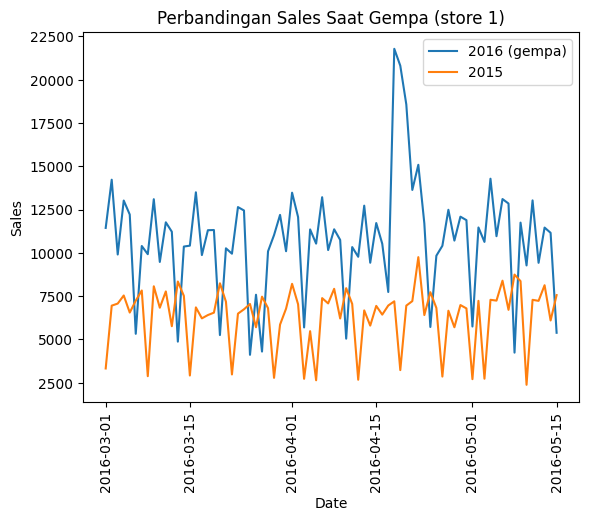

In [ ]:
plt.plot(gempa_df['date'], gempa_df['sales'], label='2016 (gempa)')
plt.plot(gempa_df['date'], nogempa_df['sales'], label='2015')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Sales')
plt.title('Perbandingan Sales Saat Gempa (store 1)')
plt.legend()
plt.show()

## **Trend**

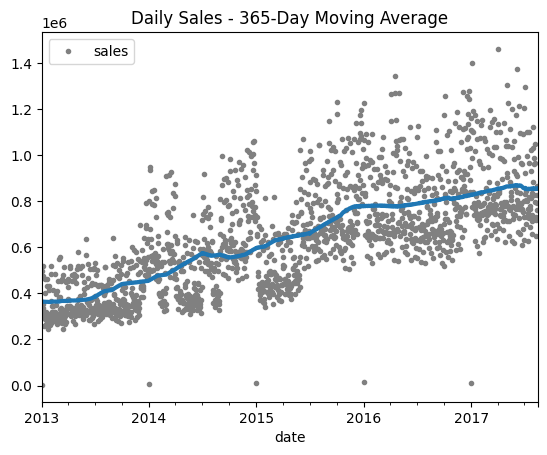

In [ ]:
moving_average = day_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = day_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Daily Sales - 365-Day Moving Average", legend=False,
);

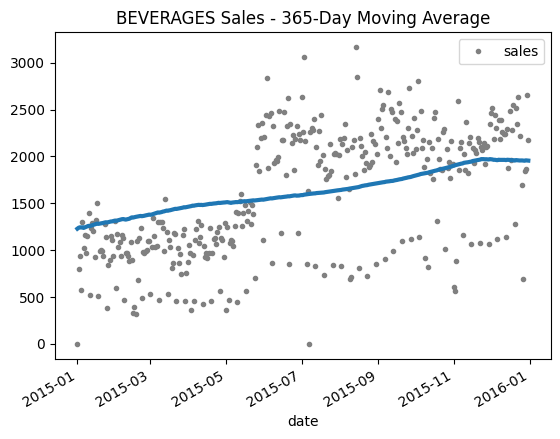

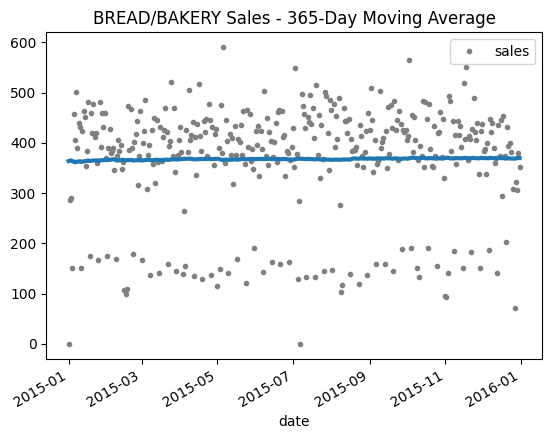

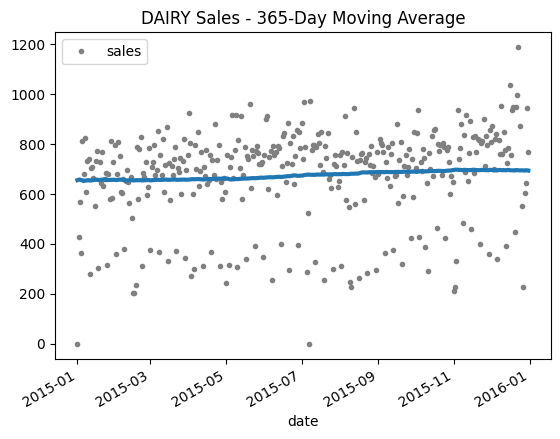

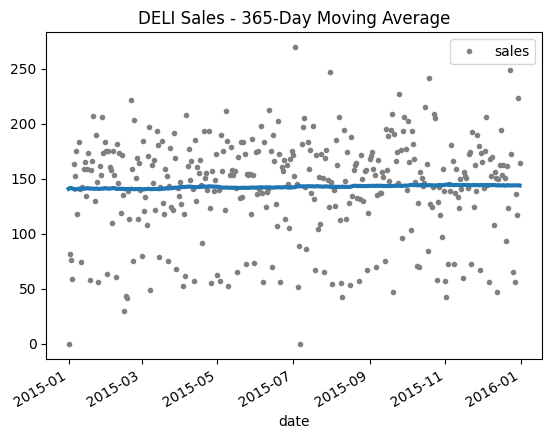

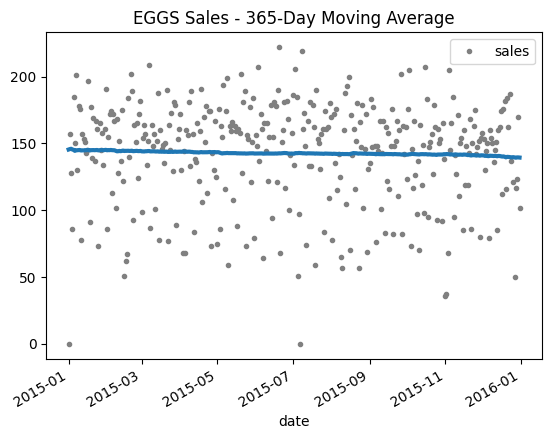

In [ ]:
cols = ['BEVERAGES','BREAD/BAKERY','DAIRY','DELI','EGGS']
for i in cols:
    fam_sales = daily_sales[daily_sales['family'] == i]
    fam_sales = fam_sales[['date','sales']]
    day_sales = fam_sales.set_index('date')
    moving_average = day_sales.rolling(
    window=365,      
    center=True,     
    min_periods=183).mean()             
    ax = day_sales.plot(style=".", color="0.5")
    moving_average.plot(ax=ax, linewidth=3, title=i + " Sales - 365-Day Moving Average", legend=False);

# **Data Preparation**

## **Finding Missing Value**

In [ ]:
tgl = pd.DataFrame({'date': pd.date_range(start='2013-01-01', end='2017-08-15', freq='D')},
                   dtype='datetime64[s]')

tgl['date'] = pd.to_datetime(tgl['date'], format='%Y-%m-%d')
#tgl['date'] = tgl['date'].dt.strftime('%Y-%m-%d')
tgl.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1688 entries, 0 to 1687

Data columns (total 1 columns):

 #   Column  Non-Null Count  Dtype        

---  ------  --------------  -----        

 0   date    1688 non-null   datetime64[s]

dtypes: datetime64[s](1)

memory usage: 13.3 KB


In [ ]:
df_train2 = pd.merge(tgl, df_train, on='date', how='left')
df_train2['date'] = pd.to_datetime(df_train2['date'], format='%Y-%m-%d')

df_train2.info()
df_train2.tail()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3000892 entries, 0 to 3000891

Data columns (total 5 columns):

 #   Column       Dtype         

---  ------       -----         

 0   date         datetime64[ns]

 1   store_nbr    float64       

 2   family       object        

 3   sales        float64       

 4   onpromotion  float64       

dtypes: datetime64[ns](1), float64(3), object(1)

memory usage: 114.5+ MB


date  store_nbr                      family     sales   
3000887 2017-08-15        9.0                     POULTRY   438.133  \
3000888 2017-08-15        9.0              PREPARED FOODS   154.553   
3000889 2017-08-15        9.0                     PRODUCE  2419.729   
3000890 2017-08-15        9.0  SCHOOL AND OFFICE SUPPLIES   121.000   
3000891 2017-08-15        9.0                     SEAFOOD    16.000   

         onpromotion  
3000887          0.0  
3000888          1.0  
3000889        148.0  
3000890          8.0  
3000891          0.0

In [ ]:
sales_copy = df_train2.copy()
sales_copy.loc[sales_copy.isnull().any(axis=1)] #Terdapat row yang null 

date  store_nbr family  sales  onpromotion
637956  2013-12-25        NaN    NaN    NaN          NaN
1286605 2014-12-25        NaN    NaN    NaN          NaN
1935254 2015-12-25        NaN    NaN    NaN          NaN
2585685 2016-12-25        NaN    NaN    NaN          NaN

## **Handling Missing Value**

In [ ]:
#Mengisi missing value
df_row = []
null_rows = list(['2013-12-25','2014-12-25','2015-12-25','2016-12-25'])
for i in df_train['store_nbr'].unique():
  for count, n in enumerate(df_train['family'].unique()):
    for m in null_rows:
        
        new_row = pd.DataFrame({'date': m, 
                   'store_nbr': i, 
                   'family': n, 
                   'sales': None,
                   'onpromotion': None
                    }, index=[len(df_row)])

        df_row.append(new_row)
df_roww = pd.concat(df_row, ignore_index=True, axis=0)
sales_copy = pd.concat([df_roww, sales_copy], ignore_index=True)
sales_copy = sales_copy.dropna(subset=['store_nbr'])

In [ ]:
sales_copy.loc[sales_copy.isnull().any(axis=1)]

date  store_nbr                      family  sales  onpromotion
0     2013-12-25        1.0                  AUTOMOTIVE    NaN          NaN
1     2014-12-25        1.0                  AUTOMOTIVE    NaN          NaN
2     2015-12-25        1.0                  AUTOMOTIVE    NaN          NaN
3     2016-12-25        1.0                  AUTOMOTIVE    NaN          NaN
4     2013-12-25        1.0                   BABY CARE    NaN          NaN
...          ...        ...                         ...    ...          ...
7123  2016-12-25        9.0  SCHOOL AND OFFICE SUPPLIES    NaN          NaN
7124  2013-12-25        9.0                     SEAFOOD    NaN          NaN
7125  2014-12-25        9.0                     SEAFOOD    NaN          NaN
7126  2015-12-25        9.0                     SEAFOOD    NaN          NaN
7127  2016-12-25        9.0                     SEAFOOD    NaN          NaN

[7128 rows x 5 columns]

In [ ]:
sales_copy[pd.isnull(sales_copy['store_nbr'])]

Empty DataFrame
Columns: [date, store_nbr, family, sales, onpromotion]
Index: []

Dikarenakan tanggal 25 (missing value) merupakan hari libur atau natal yang dimana seluruh toko tutup, maka kami memutuskan untuk sales diisi dengan nilai 0 (nol).

In [ ]:
#Mengisi missing value dengan 0
sales_copy = sales_copy.fillna(0)

null_rows = list(['2013-12-25','2014-12-25','2015-12-25','2016-12-25'])
for i in null_rows:
    print(sales_copy[(sales_copy['date'] == i)])

            date  store_nbr                      family  sales  onpromotion

0     2013-12-25        1.0                  AUTOMOTIVE    0.0          0.0

4     2013-12-25        1.0                   BABY CARE    0.0          0.0

8     2013-12-25        1.0                      BEAUTY    0.0          0.0

12    2013-12-25        1.0                   BEVERAGES    0.0          0.0

16    2013-12-25        1.0                       BOOKS    0.0          0.0

...          ...        ...                         ...    ...          ...

7108  2013-12-25        9.0                     POULTRY    0.0          0.0

7112  2013-12-25        9.0              PREPARED FOODS    0.0          0.0

7116  2013-12-25        9.0                     PRODUCE    0.0          0.0

7120  2013-12-25        9.0  SCHOOL AND OFFICE SUPPLIES    0.0          0.0

7124  2013-12-25        9.0                     SEAFOOD    0.0          0.0



[1782 rows x 5 columns]

            date  store_nbr                      

In [ ]:
sales_copy['date'] = pd.to_datetime(sales_copy['date'], format="%Y-%m-%d") #Index tanggal belum "time-series" (akan diurutkan dalam pembuatan kombinasi data)
sales_copy.info()

<class 'pandas.core.frame.DataFrame'>

Index: 3008016 entries, 0 to 3008019

Data columns (total 5 columns):

 #   Column       Dtype         

---  ------       -----         

 0   date         datetime64[ns]

 1   store_nbr    float64       

 2   family       object        

 3   sales        float64       

 4   onpromotion  float64       

dtypes: datetime64[ns](1), float64(3), object(1)

memory usage: 137.7+ MB


## **Grouping with Label Encoder**

In [ ]:
store_list = []
store_unique = np.sort(sales_copy['store_nbr'].unique()) #Data toko
for i in store_unique:
  store = sales_copy[sales_copy['store_nbr'] == i]
  store_list.append(store)

In [ ]:
df_list = []
for i in store_list:
  i = i.sort_values(by=['date','family'])
  store_num = i['store_nbr'].unique()
  arr_str = np.array2string(store_num)
  arr_str = arr_str.strip("[].")
  i.rename(columns= 
           {'sales': 'sales_store' + arr_str}, 
           inplace=True)
  
  enc = LabelEncoder()
  i['family_enc'] = enc.fit_transform(i['family'])
  original_labels = enc.classes_

  i = i.drop(columns=['store_nbr','family','onpromotion'])

  i = i.set_index('date')
  #i = i.iloc[:,[2,1,0]]
  i = pd.pivot_table(
           data    = i,
           values  = 'sales_store' + arr_str,
           index   = i.index,
           columns = 'family_enc'
                           )
  i.columns = [f"family_{col}" for col in original_labels]

  df_list.append(i)

## **Handling Outliers**

In [ ]:
data = result_list[1]
family = 'family_BREAD/BAKERY'

Q1 = data[family].quantile(0.25)
Q3 = data[family].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

lower = data[family][data[family] < lower_limit]
upper = data[family][data[family] > upper_limit]

In [ ]:
def outlier_handler(list_df):
    for data in list_df:
        for family in data:
            Q1 = data[family].quantile(0.25)
            Q3 = data[family].quantile(0.75)
            IQR = Q3 - Q1
            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            new_col = np.where(data[family] < lower_limit, lower_limit,
                                         np.where(data[family] > upper_limit, upper_limit, data[family]))
            data[family] = new_col
    return list_df

In [ ]:
list_copy = df_list.copy()
result_list = outlier_handler(list_copy)

#Check if fixed
df = result_list[0]
fam = 'family_AUTOMOTIVE'
Q1 = df[fam].quantile(0.25)
Q3 = df[fam].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df[fam][df[fam] > upper_limit].to_frame()

Empty DataFrame
Columns: [family_AUTOMOTIVE]
Index: []

# **Insight**

### **Insight (1) BOOKS family**
**Penjualannya sangat sedikit, bisa jadi minat bacannya rendah**

In [ ]:
books_list = []
storeno_list = []
for index, df in enumerate(result_list):
    books_val = df['family_BOOKS'].sum()
    store_no = index+1
    storeno_list.append(store_no)
    books_list.append(books_val)
    
books_df = pd.DataFrame({'store_no':storeno_list,
                        'sum_sales':books_list})


In [ ]:
books_df.head()

store_no  sum_sales
0         1        0.0
1         2        0.0
2         3        0.0
3         4        0.0
4         5        0.0

<Axes: xlabel='store_no'>

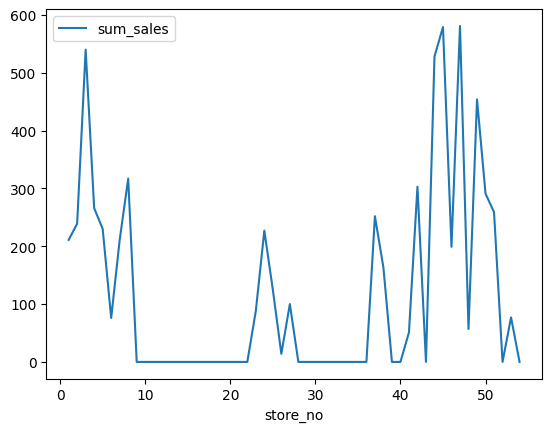

In [ ]:
books_df.set_index('store_no').plot()

### **Insight (2) Autocorrelation**
**Alasan untuk pake autoregresi**

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide

  acf = avf[: nlags + 1] / avf[0]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.

  xys = np.asarray(xys)


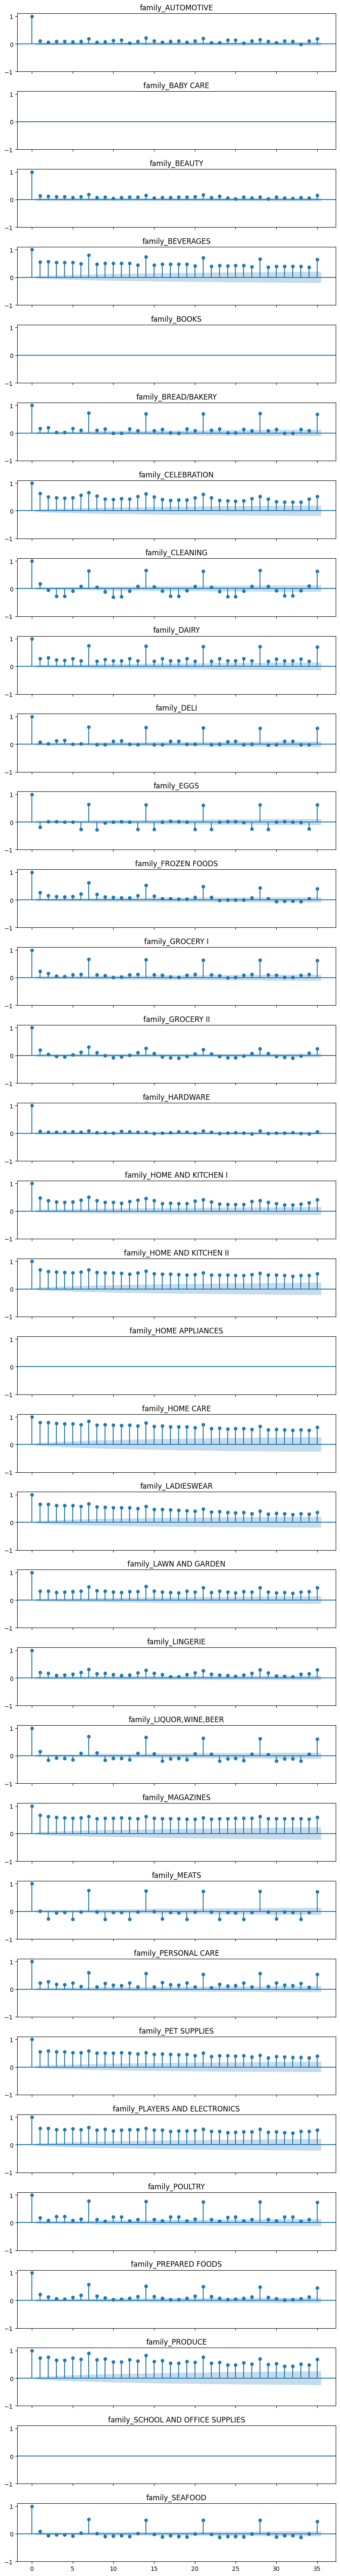

In [ ]:
# Autocorrelation plot
# ======================================================================================
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(nrows=33, ncols=1, figsize=(8, 60), sharex=True)
axes = axes.flat
for i, col in enumerate(df_list[1].columns[:]):
    plot_acf(df_list[0][col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.savefig('autocorrelation.png')
plt.show()

### **Insight(3) Decomposition**
Seasonal, Trend, Residual

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/seasonal.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

  fig, axs = plt.subplots(len(series), 1)


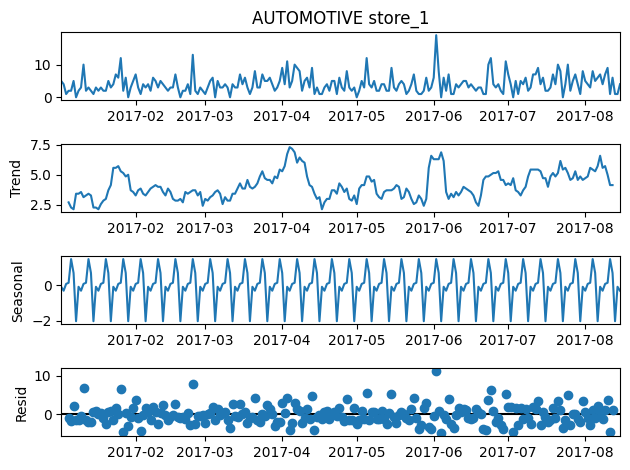

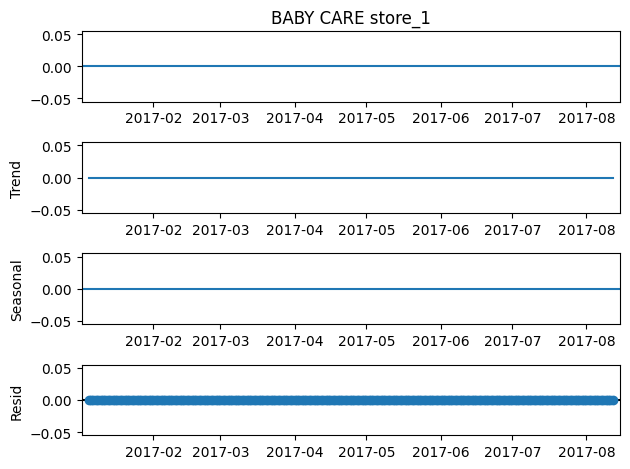

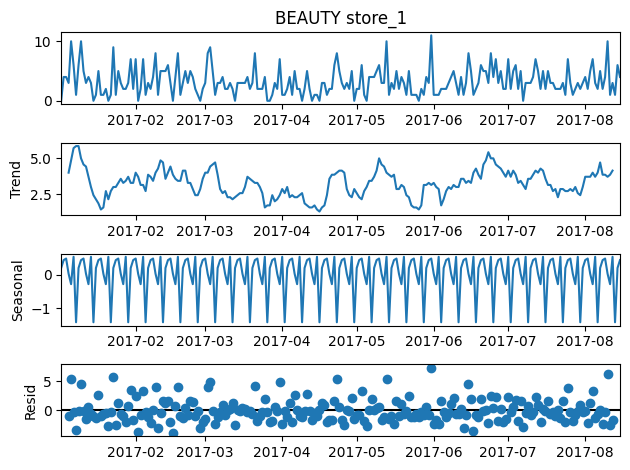

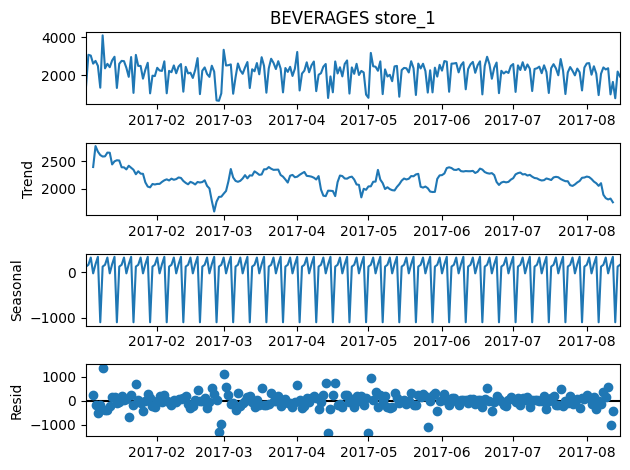

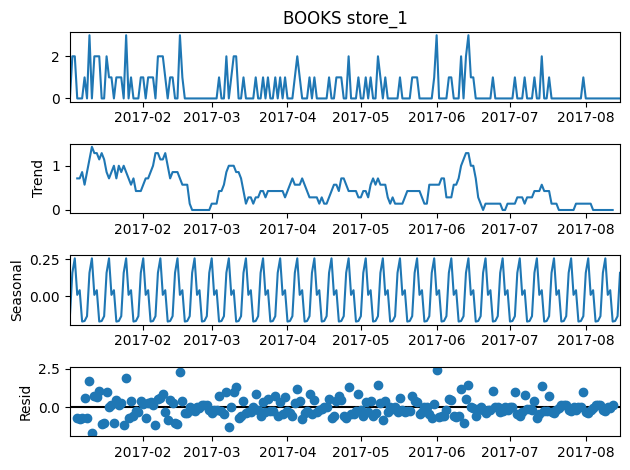

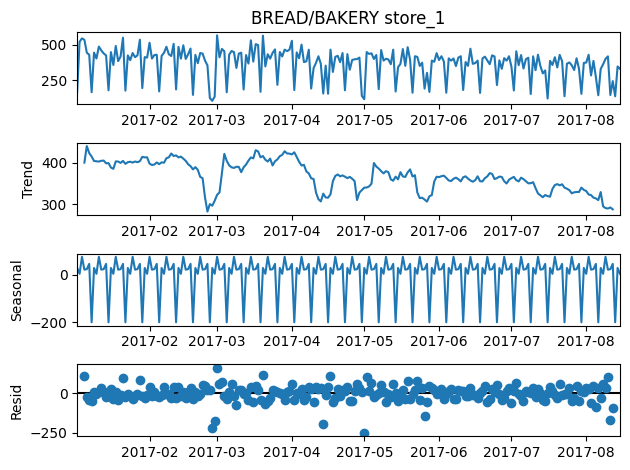

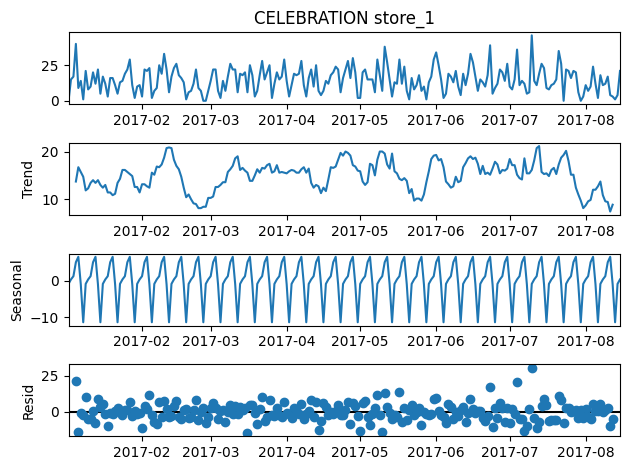

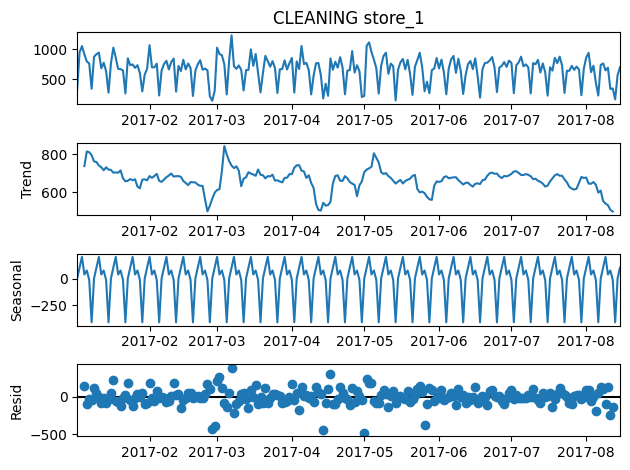

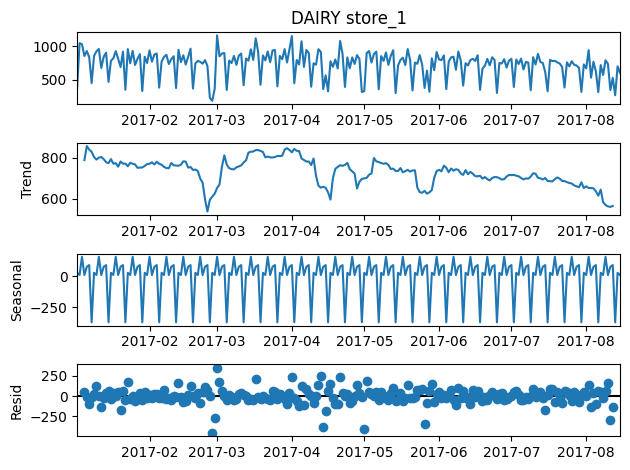

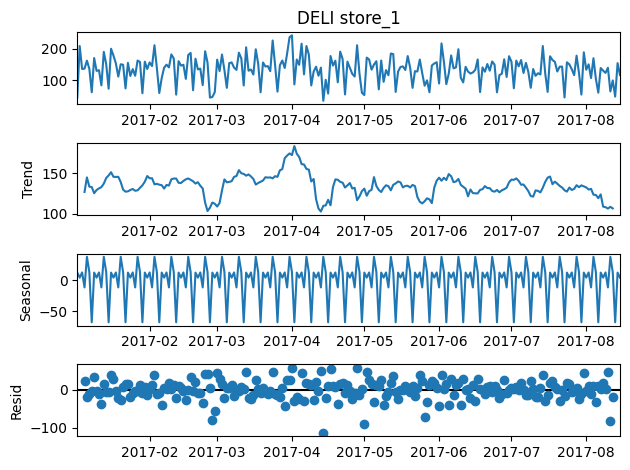

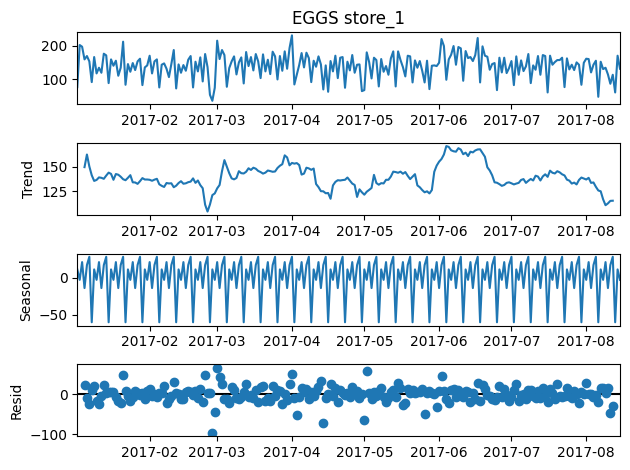

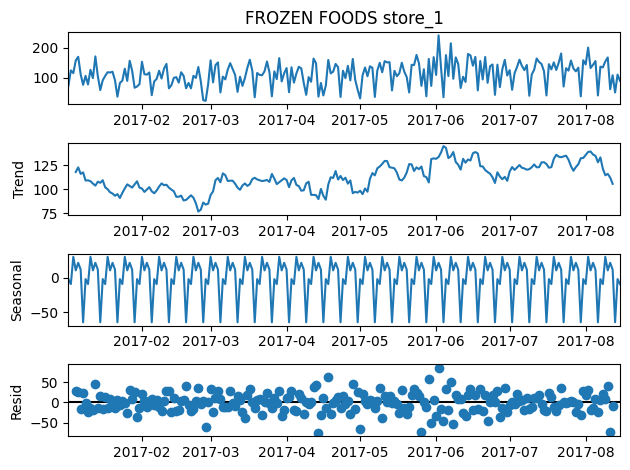

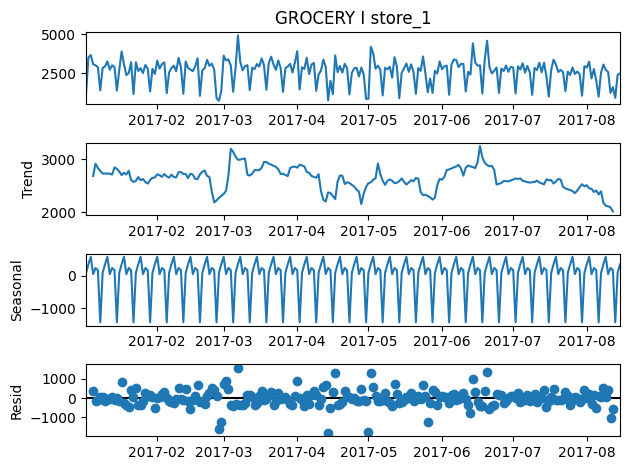

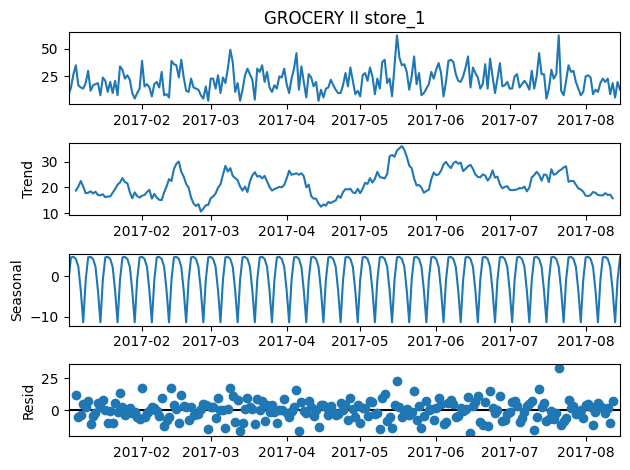

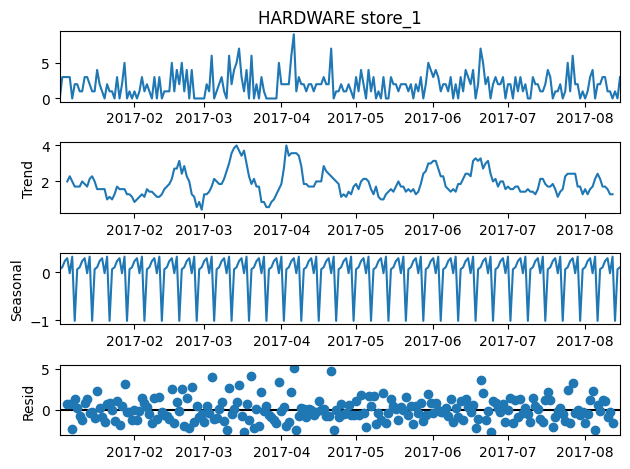

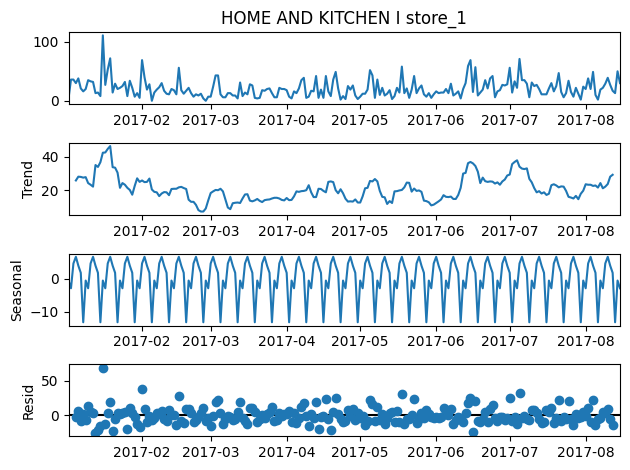

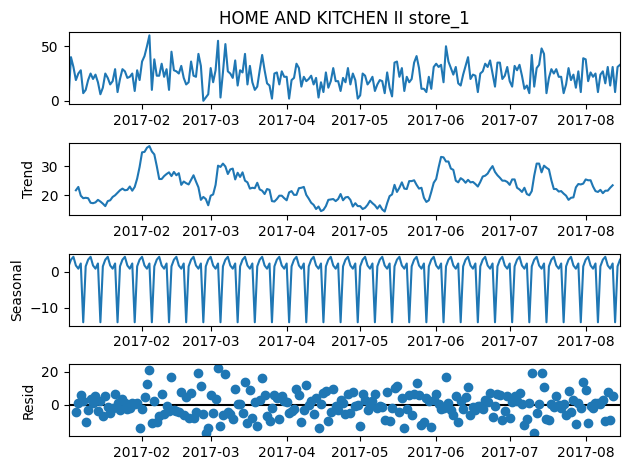

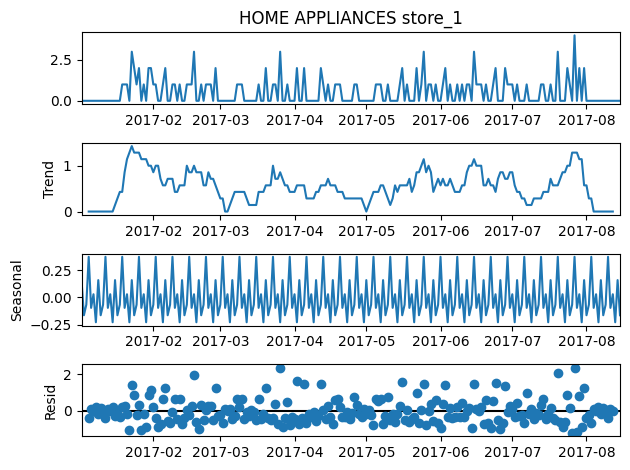

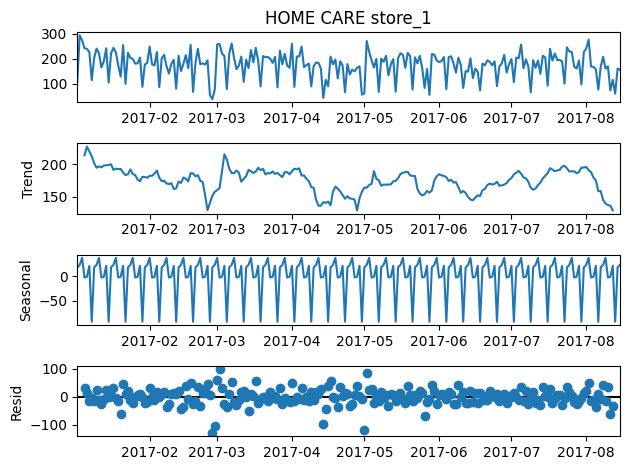

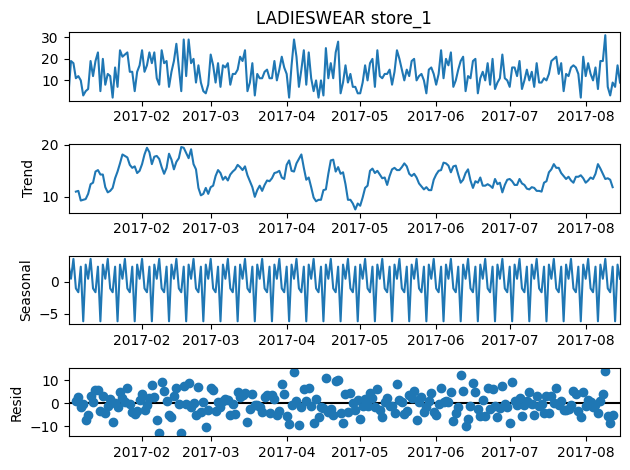

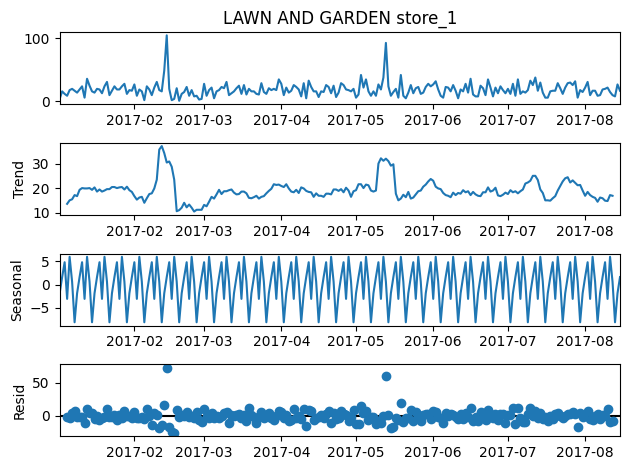

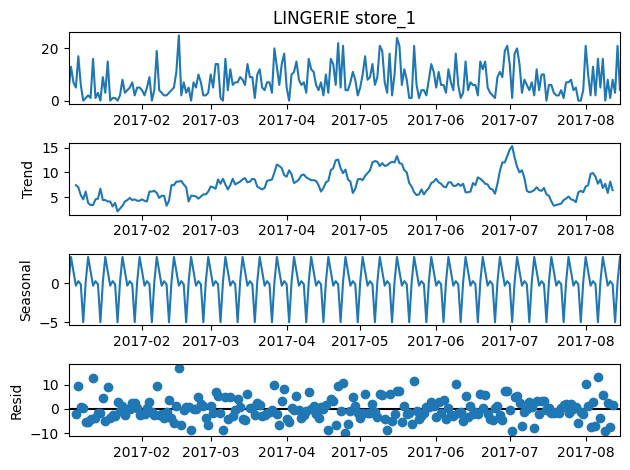

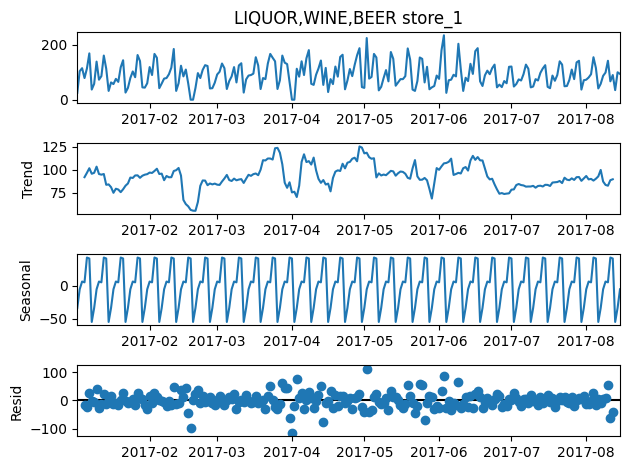

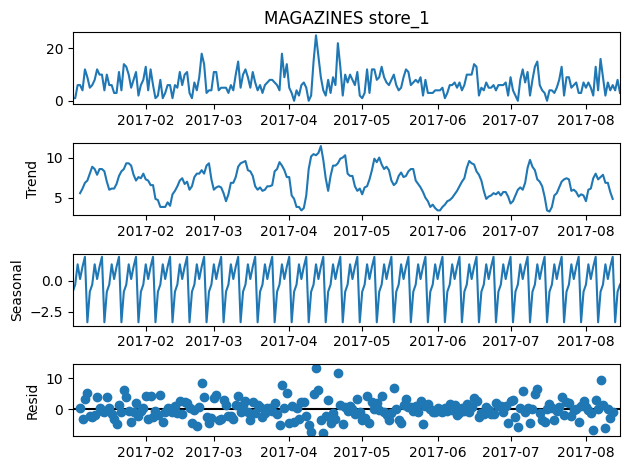

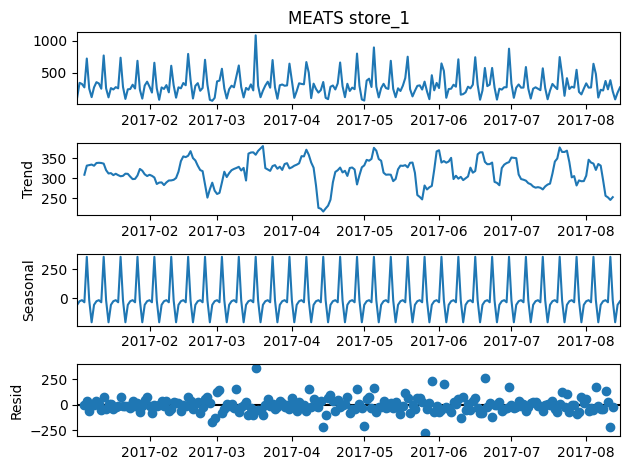

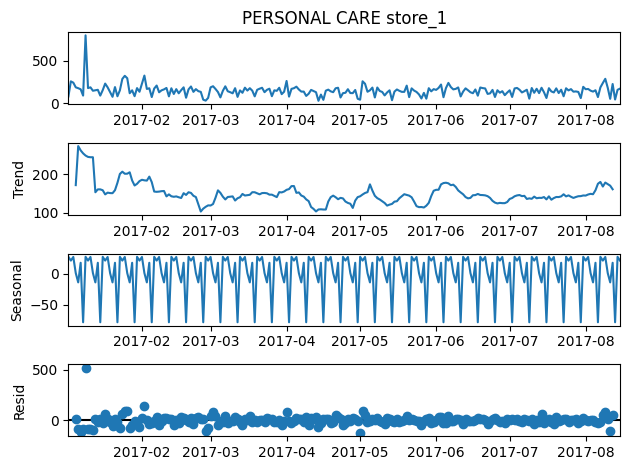

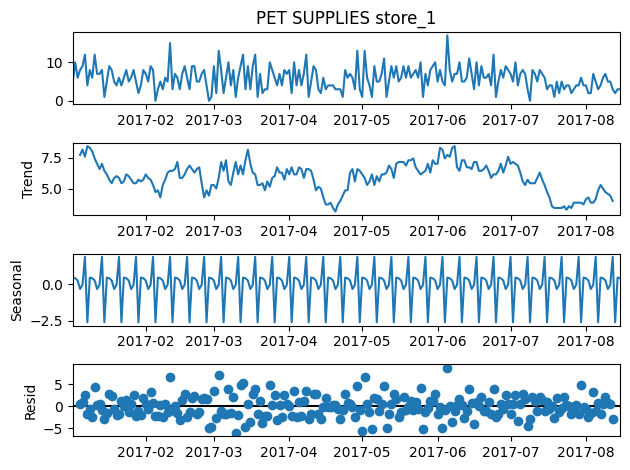

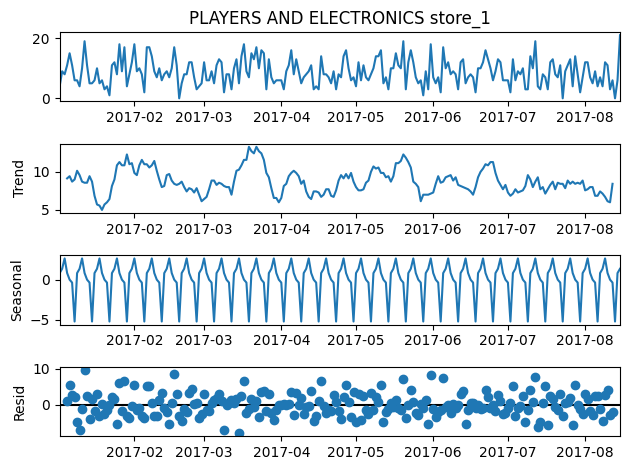

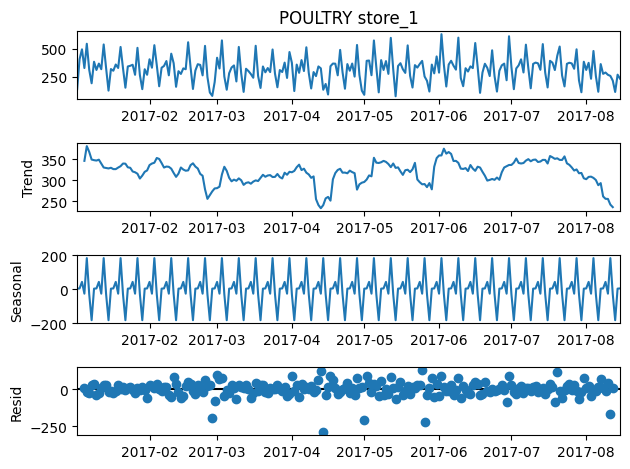

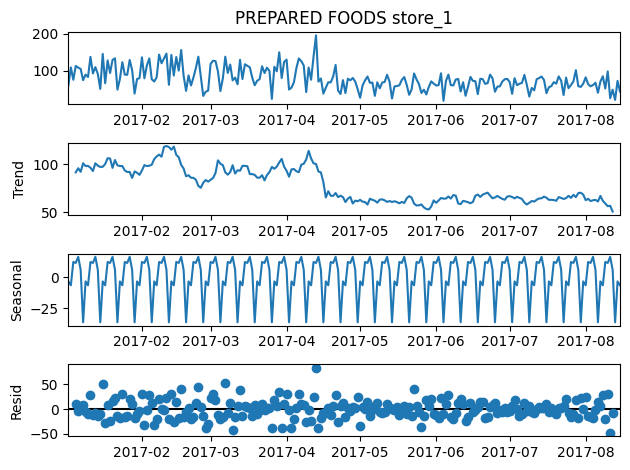

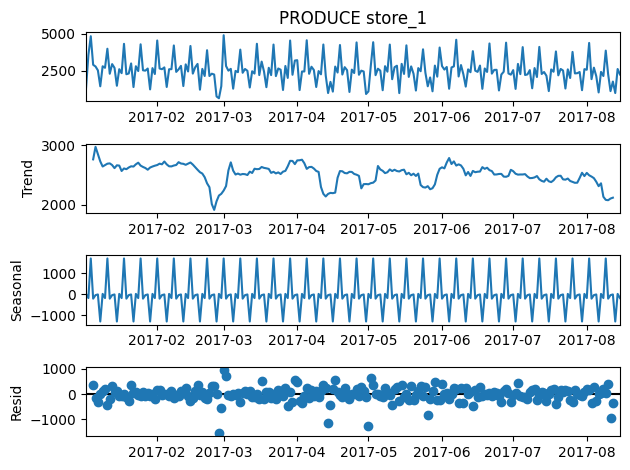

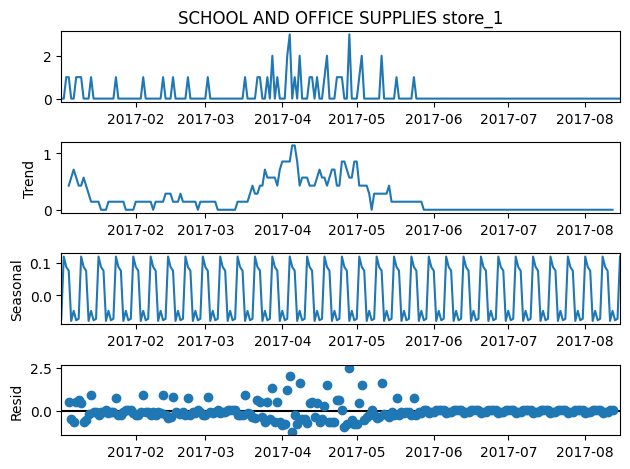

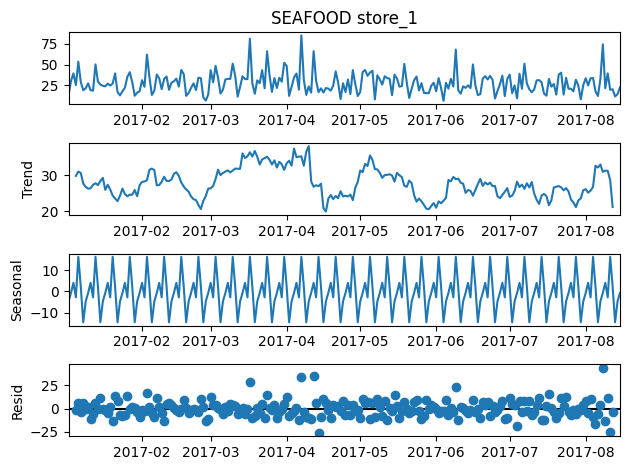

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = df_list[0]
df = df[df.index > '2017-01-01']
for index, col in enumerate(df):
    fam_name = col.split('_')[1]
    col_name = fam_name + ' store_' + str(1)
    series = df[col].rename(col_name)
    
    seasonal_decompose(series, model='additive').plot()

# **Model Comparison**
Training menggunakan **1 store** yang dimana tiap store terdiri dari **33 produk.**

## **Train Test Split**

In [ ]:
# Membuat tanggal awal dan akhir untuk data test
test_start_date = datetime(2017, 8, 1)
test_end_date = datetime(2017, 8, 15)

# Membuat tanggal awal dan akhir untuk data train
train_start_date = datetime(2013, 1, 1)
train_end_date = datetime(2017, 7, 31)

# Membuat list untuk menyimpan data train dan test
train_data = []
test_data = []
# Melakukan loop pada tiap store dalam store_list2
for store in result_list:
    # Mengambil data train dan test berdasarkan tanggal
    train = store.loc[store.index.get_level_values('date') <= train_end_date]
    test = store.loc[(store.index.get_level_values('date') >= test_start_date) & (store.index.get_level_values('date') <= test_end_date)]
    # Menambahkan data train dan test ke dalam list
    train_data.append(train)
    test_data.append(test)

In [ ]:
models_result = []

## **MultiSeries Autoregression - (Multivariate)**

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

stores_res_autoregmult = []
store_incl = train_data[:1] #Pilih jumlah store
forecast_autoregmult = []
mse_fmult_list = []
mae_fmult_list = []
rmse_fmult_list = []
rmsle_fmult_list = []

for store_index, a in enumerate(store_incl):
    X_train = a
    #data = pd.merge(a,oil_new,on='date').set_index('date')
    #X_train = data.drop(columns='dcoilwtico')
    #exogenus = data.dcoilwtico
    #a.iloc[:,:5] #bbrp kolom 
    #a.columns #semua kolom
    #exg = pd.DataFrame(a[i].shift(1))

    model =  ForecasterAutoregMultiSeries(
                 regressor     = CatBoostRegressor(random_state=123,
                                                  iterations=6000,
                                                  learning_rate=0.05,
                                                  depth=6,
                                                  l2_leaf_reg=3,
                                                  colsample_bylevel=0.9),
                                                  
                 lags          = 20,
                 transformer_series = StandardScaler() 
             )

    model.fit(series=X_train)
    forecast = model.predict(steps=15)
    forecast_autoregmult.append(forecast)
    storeno = store_index+1
    column = forecast.columns

    for i in column:
        mse = mean_squared_error(test_data[store_index][column], forecast[column])
        mae = mean_absolute_error(test_data[store_index][column], forecast[column])
        rmse = np.sqrt(mse)
        rmsle = np.sqrt(mean_squared_log_error(1+test_data[store_index][column], 1+forecast[column]))
        mse_fmult_list.append(mse)
        mae_fmult_list.append(mae)
        rmse_fmult_list.append(rmse)
        rmsle_fmult_list.append(rmsle)

mae_fautoreg_mult = sum(mae_fmult_list)
mse_fautoreg_mult = sum(mse_fmult_list)
rmse_fautoreg_mult = np.sqrt(mse_fautoreg_mult)
rmsle_fautoreg_mult = sum(rmsle_fmult_list)/len(rmsle_fmult_list)

fautoreg_mult_result = pd.DataFrame({
                   'total_mae': mae_fautoreg_mult,
                   'total_mse': mse_fautoreg_mult,
                   'total_rmse': rmse_fautoreg_mult,
                   'total_rmsle': rmsle_fautoreg_mult
                    }, index=['fautoreg_mult'])
models_result.append(fautoreg_mult_result)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Version

0:	learn: 0.9173702	total: 71.6ms	remaining: 7m 9s

1:	learn: 0.8988942	total: 79.7ms	remaining: 3m 58s

2:	learn: 0.8820467	total: 86.5ms	remaining: 2m 53s

3:	learn: 0.8660706	total: 95.7ms	remaining: 2m 23s

4:	learn: 0.8511070	total: 102ms	remaining: 2m 2s

5:	learn: 0.8375315	total: 108ms	remaining: 1m 47s

6:	learn: 0.8246495	total: 112ms	remaining: 1m 36s

7:	learn: 0.8126477	total: 117ms	remaining: 1m 27s

8:	learn: 0.8018069	total: 122ms	remaining: 1m 21s

9:	learn: 0.7918862	total: 129ms	remaining: 1m 17s

10:	learn: 0.7828978	total: 134ms	remaining: 1m 13s

11:	learn: 0.7743474	total: 140ms	remaining: 1m 9s

12:	learn: 0.7669337	total: 145ms	remaining: 1m 6s

13:	learn: 0.7597220	total: 151ms	remaining: 1m 4s

14:	learn: 0.7529447	total: 155ms	remaining: 1m 1s

15:	learn: 0.7466840	total: 159ms	remaining: 59.6s

16:	learn: 0.7409044	total: 164ms	remaining: 57.7s

17:	learn: 0.7356448	total: 168ms	remaining: 55.9s

18:	learn: 0.7309124	total: 173ms	remaining: 54.4s

19:	learn

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Lib

In [ ]:
fautoreg_mult_result

mae            mse        rmse     rmsle
fautoreg_mult  1552.469443  674080.164704  821.023851  0.357343

In [ ]:
rmsle_fmult_list[0]

0.3573429557899239

In [ ]:
for i in models_result:
    display(i)

mae            mse        rmse     rmsle
fautoreg_mult  1552.469443  674080.164704  821.023851  0.357343

## **ForecasterAutoregression - (Univariate)**

In [ ]:
stores_res_autoreg = []
store_incl = train_data[:1] #Pilih jumlah store
forecast_autoreg = []
mae_list = []
mse_list = []
rmse_list = []
rmsle_list = []

for store_index, a in enumerate(store_incl):
    store_items = a.columns
    #a.iloc[:,:5] #bbrp kolom 
    #a.columns #semua kolom
    fam_index = []
    storeno_list = []
    for n, i in enumerate(store_items):
        
        #data = pd.merge(a[i],oil_new,on='date')
        model =  ForecasterAutoreg(
                     regressor     = XGBRegressor(),
                     lags          = 20,
                     transformer_y = StandardScaler()
                 )
        model.fit(a[i])
        forecast = model.predict(steps=15)
        storeno = store_index+1
        forecast = pd.DataFrame(forecast)
        forecast = forecast.rename(columns={'pred': 'store' + str(storeno) + '_' + str(i)})
        forecast_autoreg.append(forecast)

        mae = mean_absolute_error(test_data[store_index][i], forecast)
        mse = mean_squared_error(test_data[store_index][i], forecast)
        rmse = np.sqrt(mse)
        rmsle = np.sqrt(mean_squared_log_error(1+test_data[store_index][i], 1+forecast))

        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        rmsle_list.append(rmsle)
        fam_index.append(i)
        storeno_list.append(storeno)
        
        # Results
start_date = '2017-08-01'
end_date = '2017-08-15'
dates = pd.date_range(start=start_date, end=end_date, freq='D')
date_col = pd.DataFrame({'date': dates})

fautoreg_forecast = []
for i in forecast_autoreg:
    i = i.reset_index()
    date_indexed = pd.concat([date_col, i],axis=1, ignore_index=False)
    date_indexed = date_indexed.drop(columns=['index'], axis=1)
    date_indexed = date_indexed.set_index('date')
    fautoreg_forecast.append(date_indexed)

mae_fautoreg = sum(mae_list)
mse_fautoreg = sum(mse_list)
rmse_fautoreg = np.sqrt(mse_fautoreg)
rmsle_fautoreg = sum(rmsle_list)/len(rmsle_list)
fautoreg_result = pd.DataFrame({
                   'total_mae': mae_fautoreg,
                   'total_mse': mse_fautoreg,
                   'total_rmse': rmse_fautoreg,
                   'total_mean_rmsle': rmsle_fautoreg
                    }, index=['fautoreg'])
models_result.append(fautoreg_result)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Pyth

In [ ]:
for i in models_result:
    display(i)

mae            mse        rmse     rmsle
fautoreg_mult  1552.469443  674080.164704  821.023851  0.357343

mae            mse        rmse    rmsle
fautoreg  1699.390486  779173.170362  882.707862  0.33784

## **SARIMA - (Univariate)**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer

stores_res_arima = []
store_incl = train_data[:1] #Masukkin 2 store doang
forecast_arima = []
mae_sarima_list = []
mse_sarima_list = []
rmse_sarima_list = []
rmsle_sarima_list = []

for store_index, a in enumerate(store_incl):
    store_items = a.columns
    #a.iloc[:,:5] #bbrp kolom 
    #a.columns #semua kolom

    storeno_list = []
    
    for n, i in enumerate(store_items):
        model = auto_arima(y=a[i],
                           #X=exg_train,
                           start_p=0,
                           d=1,
                           start_q=0,
                           max_p=5,
                           max_d=5,
                           max_q=5,
                           start_P=0,
                           D=1,
                           start_Q=0,
                           max_P=5,
                           max_D=5,
                           max_Q=5,
                           #m=12,
                           seasonal=False,
                           error_action='warn',
                           trace=True,
                           stepwise=True, 
                           suppress_warnings=True
                           )

        forecast = model.predict(n_periods=15)
        storeno = store_index+1
        forecast = pd.DataFrame(forecast)
        forecast = forecast.rename(columns={0: 'store' + str(storeno) + '_' + str(i)})
        forecast_arima.append(forecast)

        mae = mean_absolute_error(test_data[store_index][i], forecast)
        mse = mean_squared_error(test_data[store_index][i], forecast)
        rmse = np.sqrt(mse)
        rmsle = np.sqrt(mean_squared_log_error(1+test_data[store_index][i], 1+forecast))
        
        mae_sarima_list.append(mae)
        mse_sarima_list.append(mse)
        rmse_sarima_list.append(rmse)
        rmsle_sarima_list.append(rmsle)
        # Results
mae_sarima = sum(mae_sarima_list)
mse_sarima = sum(mse_sarima_list)
rmse_sarima = np.sqrt(mse_sarima)
rmsle_sarima = sum(rmsle_list)/len(rmsle_list)

sarima_result = pd.DataFrame({
                   'total_mae': mae_sarima,
                   'total_mse': mse_sarima,
                   'total_rmse': rmse_sarima,
                   'total_mean_rmsle': rmsle_sarima
                    }, index=['SARIMA'])
models_result.append(sarima_result)

Performing stepwise search to minimize aic

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8922.419, Time=0.31 sec

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8501.195, Time=0.13 sec

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7793.975, Time=0.76 sec

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8920.422, Time=0.04 sec

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7795.973, Time=0.76 sec

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7795.973, Time=0.65 sec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7791.887, Time=1.03 sec

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7792.960, Time=1.18 sec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7792.871, Time=1.52 sec

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7792.631, Time=0.86 sec

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7792.869, Time=0.50 sec

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.13 sec

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7791.919, Time=0.31 sec



Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept

Total fit time: 10.233 seconds

 ARIMA(0,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.

  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7028.919, Time=0.09 sec

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6456.879, Time=0.27 sec

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7484.651, Time=0.03 sec

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6456.740, Time=0.37 sec

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6457.923, Time=0.49 sec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6460.057, Time=0.50 sec

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6456.837, Time=0.36 sec

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6844.469, Time=0.12 sec

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6458.519, Time=1.32 sec

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6455.144, Time=0.17 sec

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6455.194, Time=0.10 sec

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7026.920, Time=0.06 sec

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6456.412, Time=0.23 sec

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6458.020, Time=0.41 sec

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6455.233, Time=0.15 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.

  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20844.894, Time=0.11 sec

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20221.234, Time=0.54 sec

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21361.360, Time=0.02 sec

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20223.066, Time=0.78 sec

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20223.074, Time=0.49 sec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20180.624, Time=0.70 sec

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20172.344, Time=1.05 sec

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20223.950, Time=1.30 sec

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.95 sec

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20028.386, Time=2.24 sec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20174.201, Time=1.65 sec

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.89 sec

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.91 sec

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=20165.758, Time=1.42 sec

 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=19935.612, Time=3.04 sec

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.

  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17732.788, Time=0.14 sec

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17464.805, Time=0.26 sec

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18173.542, Time=0.03 sec

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17465.085, Time=0.44 sec

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17465.318, Time=0.40 sec

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17412.776, Time=1.16 sec

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17463.123, Time=1.25 sec

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17413.399, Time=1.09 sec

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=17460.664, Time=0.70 sec

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17462.118, Time=0.63 sec

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17355.808, Time=1.20 sec

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17041.211, Time=2.62 sec

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17384.330, Time=1.49 sec

 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=16989.038, Time=3.31 sec

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17329.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.

  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13321.408, Time=0.20 sec

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13632.427, Time=0.04 sec

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13132.534, Time=0.32 sec

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13032.860, Time=0.41 sec

 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12988.094, Time=0.56 sec

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=12898.027, Time=0.72 sec

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12569.403, Time=1.45 sec

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12612.794, Time=1.42 sec

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=12576.172, Time=1.86 sec

 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12574.985, Time=1.65 sec

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=12567.406, Time=0.61 sec

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=12610.799, Time=0.53 sec

 ARIMA(5,1,0)(0,0,0)[0]             : AIC=12896.028, Time=0.31 sec

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=12573.688, T

In [ ]:
for i in models_result:
    display(i)

mae            mse        rmse     rmsle
fautoreg_mult  1552.469443  674080.164704  821.023851  0.357343

mae            mse        rmse    rmsle
fautoreg  1699.390486  779173.170362  882.707862  0.33784

total_mae     total_mse   total_rmse  total_mean_rmsle
SARIMA  2542.296774  1.654262e+06  1286.181296           0.33784

## **Long-Short Term Memory (LSTM) - (Univariate)**


In [ ]:
fam_index = []
mae_lstm_list = []
mse_lstm_list = []
rmse_lstm_list = []
rmsle_lstm_list = []
storeno_list = []
stores_res_lstm = []
store_incl = train_data[:1] #Masukkin 2 store doang
forecast_lstm = []
for store_index, a in enumerate(store_incl):
    store_items = a.columns
    #a.iloc[:,:5] #bbrp kolom 
    #a.columns #semua kolom

    
    for n, i in enumerate(store_items):
        train = a[i]
        train = train.values.reshape((train.shape[0], 1, 1))
        model = Sequential()
        model.add(LSTM(units=64, input_shape=(1, 1)))
        model.add(Dense(units=1))
        model.compile(optimizer= Adam(learning_rate=0.001), loss='mean_squared_error')

        # Latih model
        model.fit(train ,train, epochs=25, batch_size=1, verbose=0)

        # Buat prediksi
        forecast = model.predict(test_data[store_index][i])
        #forecast = round(model.predict(n_periods=15))
        storeno = store_index+1
        forecast = pd.DataFrame(forecast)
        forecast = forecast.rename(columns={0: 'store' + str(storeno) + '_' + str(i)})
        forecast_lstm.append(forecast)

        mae = mean_absolute_error(test_data[store_index][i], forecast)
        mse = mean_squared_error(test_data[store_index][i], forecast)
        rmse = np.sqrt(mse)
        rmsle = np.sqrt(mean_squared_log_error(1+test_data[store_index][i], 1+forecast))
        
        mae_lstm_list.append(mae)
        mse_lstm_list.append(mse)
        rmse_lstm_list.append(rmse)
        rmsle_lstm_list.append(rmsle)
        fam_index.append(i)
        storeno_list.append(storeno)
        # Results
mae_lstm = sum(mae_lstm_list)
mse_lstm = sum(mse_lstm_list)
rmse_lstm = np.sqrt(mse_lstm)
rmsle_lstm = sum(rmsle_lstm_list)/len(rmsle_lstm_list)

lstm_result = pd.DataFrame({
                   'total_mae': mae_lstm,
                   'total_mse': mse_lstm,
                   'total_rmse': rmse_lstm,
                   'total_mean_rsmle': rmsle_lstm
                    }, index=['LSTM'])
models_result.append(lstm_result)

2023-06-08 07:04:08.593524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:04:08.596442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:04:08.597668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 480ms/step


2023-06-08 07:04:54.311743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:04:54.313385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:04:54.314530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 363ms/step


2023-06-08 07:05:37.913650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:05:37.915359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:05:37.916813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 371ms/step


2023-06-08 07:06:25.456532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:06:25.457800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:06:25.459119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 330ms/step


2023-06-08 07:07:08.121694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:07:08.123056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:07:08.124730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

2023-06-08 07:07:54.703843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:07:54.705087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:07:54.707078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 365ms/step


2023-06-08 07:07:55.027003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:07:55.028131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:07:55.029344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

2023-06-08 07:08:39.635092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:08:39.636449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:08:39.638022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 375ms/step


2023-06-08 07:08:39.971103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:08:39.972214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:08:39.973494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 1s 515ms/step


2023-06-08 07:09:25.538268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:09:25.544335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:09:25.546629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 379ms/step


2023-06-08 07:10:14.474150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:10:14.475727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:10:14.477306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 369ms/step


2023-06-08 07:11:01.568593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:11:01.569992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:11:01.571380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 374ms/step


2023-06-08 07:11:46.485718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:11:46.487066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:11:46.490576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 349ms/step


2023-06-08 07:12:29.815720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:12:29.817043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:12:29.818401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 352ms/step


2023-06-08 07:13:12.525314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:13:12.526718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:13:12.528030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 373ms/step


2023-06-08 07:13:57.267071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:13:57.268590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:13:57.270637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 384ms/step


2023-06-08 07:14:41.708553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:14:41.709926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:14:41.711834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 354ms/step


2023-06-08 07:15:25.041779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:15:25.043059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:15:25.044376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 366ms/step


2023-06-08 07:16:10.540600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:16:10.541967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:16:10.543425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 412ms/step


2023-06-08 07:17:00.313726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:17:00.315732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:17:00.319180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 414ms/step


2023-06-08 07:17:54.888112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:17:54.889574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:17:54.891221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 1s 694ms/step


2023-06-08 07:18:58.336515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:18:58.338658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:18:58.340464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 404ms/step


2023-06-08 07:19:51.872511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:19:51.873876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:19:51.875698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 395ms/step


2023-06-08 07:20:41.112372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:20:41.113685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:20:41.115368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 399ms/step


2023-06-08 07:21:30.481052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:21:30.482903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:21:30.484976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 368ms/step


2023-06-08 07:22:21.143364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:22:21.145230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:22:21.146554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 359ms/step


2023-06-08 07:23:05.168938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:23:05.170651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:23:05.172006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 367ms/step


2023-06-08 07:23:49.999885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:23:50.001352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:23:50.002894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 358ms/step


2023-06-08 07:24:34.764812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:24:34.766151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:24:34.767590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 415ms/step


2023-06-08 07:25:21.455808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:25:21.457208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:25:21.459015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 396ms/step


2023-06-08 07:26:11.174933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:26:11.176652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:26:11.178150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 381ms/step


2023-06-08 07:26:55.756470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:26:55.757764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:26:55.759297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 483ms/step


2023-06-08 07:27:43.729377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:27:43.733744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:27:43.735380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 361ms/step


2023-06-08 07:28:35.826390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:28:35.827699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:28:35.829278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 1s 592ms/step


2023-06-08 07:29:36.336640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:29:36.338346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:29:36.340065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

1/1 [==============================] - 0s 497ms/step


2023-06-08 07:30:42.049208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32

	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]

2023-06-08 07:30:42.051496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32

	 [[{{node gradients/split_grad/concat/split/split_dim}}]]

2023-06-08 07:30:42.058915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You

In [ ]:
for i in models_result:
    display(i)

total_mae      total_mse  total_rmse  total_mean_rmsle
fautoreg_mult  1552.469443  674080.164704  821.023851          0.357343

total_mae      total_mse  total_rmse  total_mean_rmsle
fautoreg  1699.390486  779173.170362  882.707862           0.33784

total_mae     total_mse   total_rmse  total_mean_rmsle
SARIMA  2542.296774  1.654262e+06  1286.181296           0.33784

total_mae     total_mse   total_rmse  total_mean_rsmle
LSTM  4263.338368  7.492376e+06  2737.220532          0.113086

In [ ]:
models_result[0] = models_result[0].rename(columns={'mae':'total_mae',
                                'mse':'total_mse',
                                'rmse':'total_rmse',
                                'rmsle':'total_mean_rmsle'})

models_result[1] = models_result[1].rename(columns={'mae':'total_mae',
                                'mse':'total_mse',
                                'rmse':'total_rmse',
                                'rmsle':'total_mean_rmsle'})
models_result[3] = models_result[3].rename(columns={
                                'total_mean_rsmle':'total_mean_rmsle'})

In [ ]:
pd.concat(models_result)

total_mae     total_mse   total_rmse  total_mean_rmsle
fautoreg_mult  1552.469443  6.740802e+05   821.023851          0.357343
fautoreg       1699.390486  7.791732e+05   882.707862          0.337840
SARIMA         2542.296774  1.654262e+06  1286.181296          0.337840
LSTM           4263.338368  7.492376e+06  2737.220532          0.113086

In [ ]:
forecast_arima[3]

store1_family_BEVERAGES
2017-08-01              2099.605653
2017-08-02              2099.605653
2017-08-03              2099.605653
2017-08-04              2099.605653
2017-08-05              2099.605653
2017-08-06              2099.605653
2017-08-07              2099.605653
2017-08-08              2099.605653
2017-08-09              2099.605653
2017-08-10              2099.605653
2017-08-11              2099.605653
2017-08-12              2099.605653
2017-08-13              2099.605653
2017-08-14              2099.605653
2017-08-15              2099.605653

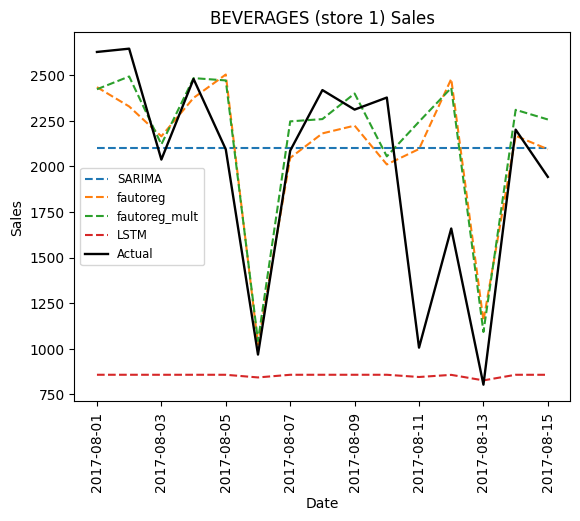

<Figure size 1000x4000 with 0 Axes>

In [ ]:
plt.plot(forecast_arima[3].index, forecast_arima[3].iloc[:,0], 
         label='SARIMA',
         linestyle='--')
plt.plot(fautoreg_forecast[3].index, fautoreg_forecast[3].iloc[:,0], 
         label='fautoreg',
         linestyle='--')
plt.plot(test_data[0].index, forecast_autoregmult[0]['family_BEVERAGES'], 
         label='fautoreg_mult',
         linestyle='--')

plt.plot(test_data[0].index,
        forecast_lstm[3],
        label='LSTM',
        linestyle='--')

plt.plot(test_data[0].index, 
        test_data[0]['family_BEVERAGES'],
         color='black', 
         linewidth=1.7, 
         markersize=1,
         label='Actual'
        )

plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.title('BEVERAGES (store 1) Sales')
plt.legend(fontsize='small')
plt.figure(figsize=(10, 40)) 
plt.savefig('compare_models.png')
plt.show()

In [ ]:
#Hasil evaluasi model-model
models_metrics = pd.concat(models_result)
models_metrics

total_mae     total_mse   total_rmse  total_mean_rmsle
fautoreg_mult  1552.469443  6.740802e+05   821.023851          0.357343
fautoreg       1699.390486  7.791732e+05   882.707862          0.337840
SARIMA         2542.296774  1.654262e+06  1286.181296          0.337840
LSTM           4263.338368  7.492376e+06  2737.220532          0.113086

# **Best Model: ForecasterAutoregMultiSeries**

### **Making forecast**
from **2017-08-16** to **2017-08-31**

## **Forecast Data**

In [ ]:
fore_start_date = datetime(2013, 1, 1)
fore_end_date = datetime(2017, 8, 15)

train_forecast = []

for store in result_list:
    train = store.loc[store.index.get_level_values('date') <= fore_end_date]
    train_forecast.append(train)

## **Forecasting**

In [ ]:
store_incl = train_forecast[:2] #Pilih jumlah store
predict_autoregmult = []

for store_index, a in enumerate(store_incl):
    X_train = a
    model =  ForecasterAutoregMultiSeries(
                 regressor     = CatBoostRegressor(random_state=123,
                                                  iterations=6000,
                                                  learning_rate=0.05,
                                                  depth=6,
                                                  l2_leaf_reg=3,
                                                  colsample_bylevel=0.9),
                 lags          = 20,
                 transformer_series = StandardScaler()
             )
    model.fit(X_train)
    forecast = model.predict(steps=15)
    predict_autoregmult.append(forecast)
    
start_date = '2017-08-16'
end_date = '2017-08-30'
dates = pd.date_range(start=start_date, end=end_date, freq='D')
date_col = pd.DataFrame({'date': dates})

predict_fautoregmult = []
for i in predict_autoregmult:
    i = i.reset_index()
    #date_col = date_col.reset_index()
    date_indexed = pd.concat([date_col, i],axis=1, ignore_index=False)
    date_indexed = date_indexed.drop(columns=['index'], axis=1)
    date_indexed = date_indexed.set_index('date')
    predict_fautoregmult.append(date_indexed)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:789: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Version

0:	learn: 0.9171154	total: 4.74ms	remaining: 28.5s

1:	learn: 0.8987170	total: 10.1ms	remaining: 30.2s

2:	learn: 0.8815854	total: 14.8ms	remaining: 29.6s

3:	learn: 0.8656832	total: 19.2ms	remaining: 28.8s

4:	learn: 0.8508005	total: 24ms	remaining: 28.8s

5:	learn: 0.8369106	total: 29.6ms	remaining: 29.5s

6:	learn: 0.8243967	total: 34.2ms	remaining: 29.3s

7:	learn: 0.8125414	total: 38.8ms	remaining: 29.1s

8:	learn: 0.8017885	total: 43.5ms	remaining: 29s

9:	learn: 0.7923738	total: 48.1ms	remaining: 28.8s

10:	learn: 0.7833055	total: 52.3ms	remaining: 28.5s

11:	learn: 0.7748988	total: 58.1ms	remaining: 29s

12:	learn: 0.7675854	total: 65.2ms	remaining: 30s

13:	learn: 0.7606945	total: 78.2ms	remaining: 33.4s

14:	learn: 0.7539296	total: 84.8ms	remaining: 33.9s

15:	learn: 0.7472729	total: 93.5ms	remaining: 35s

16:	learn: 0.7414916	total: 102ms	remaining: 35.8s

17:	learn: 0.7360556	total: 108ms	remaining: 36s

18:	learn: 0.7311193	total: 114ms	remaining: 35.8s

19:	learn: 0.72640

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Lib

0:	learn: 0.9309614	total: 9.58ms	remaining: 57.5s

1:	learn: 0.9118107	total: 15ms	remaining: 45s

2:	learn: 0.8940060	total: 21.7ms	remaining: 43.4s

3:	learn: 0.8774237	total: 31.1ms	remaining: 46.5s

4:	learn: 0.8622537	total: 40.9ms	remaining: 49.1s

5:	learn: 0.8479846	total: 49.5ms	remaining: 49.4s

6:	learn: 0.8349649	total: 55.5ms	remaining: 47.6s

7:	learn: 0.8229211	total: 60.7ms	remaining: 45.4s

8:	learn: 0.8121269	total: 65.7ms	remaining: 43.7s

9:	learn: 0.8016546	total: 71.9ms	remaining: 43.1s

10:	learn: 0.7920551	total: 77ms	remaining: 41.9s

11:	learn: 0.7832342	total: 82.7ms	remaining: 41.3s

12:	learn: 0.7749570	total: 89.1ms	remaining: 41s

13:	learn: 0.7671306	total: 94.2ms	remaining: 40.3s

14:	learn: 0.7601197	total: 99.6ms	remaining: 39.7s

15:	learn: 0.7535794	total: 107ms	remaining: 39.8s

16:	learn: 0.7478294	total: 112ms	remaining: 39.5s

17:	learn: 0.7420723	total: 119ms	remaining: 39.4s

18:	learn: 0.7368667	total: 125ms	remaining: 39.4s

19:	learn: 0.73

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:852: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

  warnings.warn(

/Lib

## **Combine Result with Other Data**

In [ ]:
pred_copy = predict_fautoregmult.copy()

In [ ]:
dfs = pred_copy
test_dfs = []

for index, df in enumerate(dfs):
    for i in df.columns:
        fam = i.split('_')
        fam = fam[1]
        df = df.rename(columns = {i:fam})
    df = df.reset_index()
    df = pd.melt(df, 
            id_vars='date', 
            value_vars=df.columns,
            value_name='sales',
            var_name='family')
    df['store_nbr'] = index+1
    test_dfs.append(df)

In [ ]:
new_train = df_train.drop(columns='onpromotion')
test_dfss = pd.concat(test_dfs).sort_values(['date','store_nbr','family'])

In [ ]:
start_date = '2013-01-01'
end_date = '2017-08-30'
dates = pd.date_range(start=start_date, end=end_date, freq='D')
date_range = pd.DataFrame({'date': dates})

oil_new = df_oil.copy()
oil_new = pd.merge(date_range,oil_new, how='left')
oil_new = oil_new.interpolate(method='linear')
oil_new = oil_new.fillna(method='bfill')

In [ ]:
oil_new[oil_new.isnull().any(axis=1)]

Empty DataFrame
Columns: [date, dcoilwtico]
Index: []

In [ ]:
result_df = pd.merge(test_dfss, df_test, on=['date','family','store_nbr'])
final_df = pd.concat([result_df ,df_train], axis=0).sort_values(['date','store_nbr','family']).reset_index(drop=True)
final_df2 = pd.merge(final_df,oil_new, on='date',how='left')

In [ ]:
holiday1 = df_holiday.drop(columns=['type','locale','locale_name','description','transferred'])
holiday1['is_holiday'] = True
holiday1 = holiday1[holiday1.date.between('2013-01-01','2017-08-30')]
holiday2 = pd.merge(holiday1,date_range, on='date',how='right')
holiday3 = holiday2.drop_duplicates(subset='date')
holiday3 = holiday3.fillna(False)

In [ ]:
final_df3 = pd.merge(holiday3,final_df2,on='date',how='right')
final_df4 = pd.merge(final_df3,df_stores,on='store_nbr').reset_index(drop=True)
final_df5 = final_df4.copy()
final_df5['sales'] = final_df5['sales'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
final_df5

date  is_holiday                      family    sales   
0       2013-01-01        True                  AUTOMOTIVE    0.000  \
1       2013-01-01        True                   BABY CARE    0.000   
2       2013-01-01        True                      BEAUTY    0.000   
3       2013-01-01        True                   BEVERAGES    0.000   
4       2013-01-01        True                       BOOKS    0.000   
...            ...         ...                         ...      ...   
3001873 2017-08-15        True                     POULTRY   59.619   
3001874 2017-08-15        True              PREPARED FOODS   94.000   
3001875 2017-08-15        True                     PRODUCE  915.371   
3001876 2017-08-15        True  SCHOOL AND OFFICE SUPPLIES    0.000   
3001877 2017-08-15        True                     SEAFOOD    3.000   

         store_nbr  onpromotion  dcoilwtico       city      state type   
0                1            0       93.14      Quito  Pichincha    D  \
1                1            0       93.14      Quito  Pichincha    D   
2                1            0       93.14      Quito  Pichincha    D   
3                1            0       93.14      Quito  Pichincha    D   
4                1            0       93.14      Quito  Pichincha    D   
...            ...          ...         ...        ...        ...  ...   
3001873         54            0       47.57  El Carmen     Manabi    C   
3001874         54            0       47.57  El Carmen     Manabi    C   
3001875         54           76       47.57  El Carmen     Manabi    C   
3001876         54            0       47.57  El Carmen     Manabi    C   
3001877         54            0       47.57  El Carmen     Manabi    C   

         cluster  
0             13  
1             13  
2             13  
3             13  
4             13  
...          ...  
3001873        3  
3001874        3  
3001875        3  
3001876        3  
3001877        3  

[3001878 rows x 11 columns]

## **Forecast Plot**

In [ ]:
start_date = '2017-07-15'
end_date = '2017-08-15'

plot_sales = df_train[(df_train['store_nbr'] == 2) & 
                       (df_train['date'].between(start_date, end_date)) &
                       (df_train['family'] == 'BEVERAGES')
                      ]
plot_saless = plot_sales.set_index('date')
plot_salesss = plot_saless['sales']
bev2_forecast = pd.concat([plot_salesss,predict_fautoregmult[1]['family_BEVERAGES'].squeeze()],axis=0)

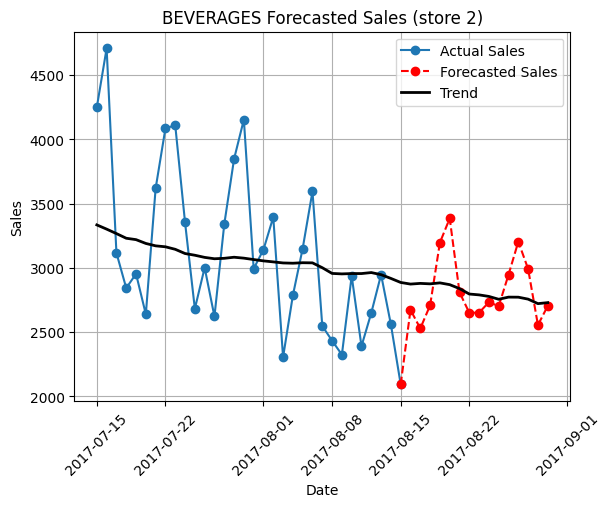

In [ ]:
# Plotting the actual and forecasted sales data for EGG
plt.plot(bev2_forecast.index[:32], 
         bev2_forecast[:32], 
         marker='o', 
         label='Actual Sales')
plt.plot(bev2_forecast.index[31:], 
         bev2_forecast[31:], 
         marker='o', 
         linestyle='--', 
         color='red', 
         label='Forecasted Sales')
ma_beverage2 = bev2_forecast.rolling(
    window=45,      
    center=True,     
    min_periods=1).mean()   
plt.plot(ma_beverage2,         
         color='black',
         linewidth=2,
         label='Trend')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.title('BEVERAGES Forecasted Sales (store 2)')
plt.grid(True)
plt.legend()
plt.savefig('store2_bev.png')
plt.show()

In [ ]:
start_date = '2017-07-15'
end_date = '2017-08-15'

plot_sales = df_train[(df_train['store_nbr'] == 2) & 
                       (df_train['date'].between(start_date, end_date)) &
                       (df_train['family'] == 'DAIRY')
                      ]
plot_saless = plot_sales.set_index('date')
plot_salesss = plot_saless['sales']
dairy_forecast = pd.concat([plot_salesss,predict_fautoregmult[1]['family_DAIRY'].squeeze()],axis=0)

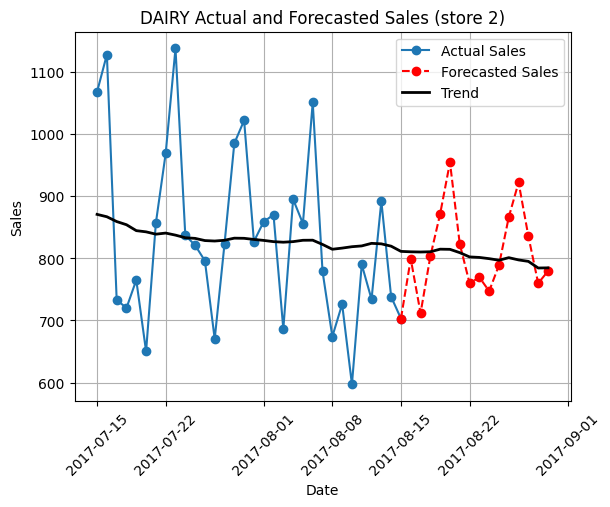

In [ ]:
# Plotting the actual and forecasted sales data for EGG
plt.plot(dairy_forecast.index[:32], 
         dairy_forecast[:32], 
         marker='o', 
         label='Actual Sales')
plt.plot(dairy_forecast.index[31:], 
         dairy_forecast[31:], 
         marker='o', 
         linestyle='--', 
         color='red', 
         label='Forecasted Sales')
ma_dairy = dairy_forecast.rolling(
    window=45,      
    center=True,     
    min_periods=1).mean()   
plt.plot(ma_dairy,         
         color='black',
         linewidth=2,
         label='Trend')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.title('DAIRY Actual and Forecasted Sales (store 2)')
plt.grid(True)
plt.legend()

plt.show()

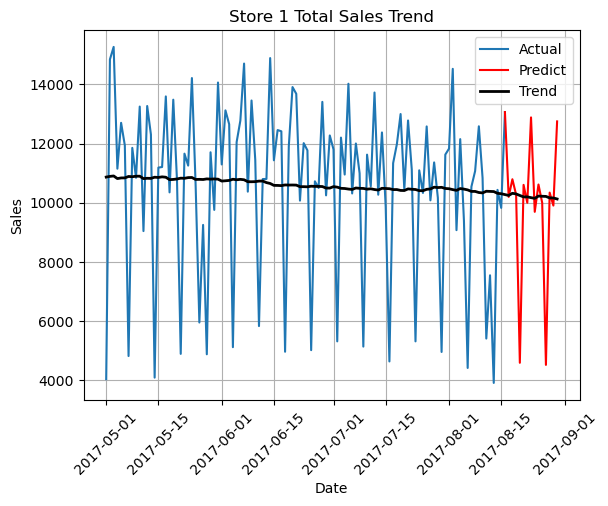

In [ ]:
store_plot = store_sales_list[0]
plt.plot(store_plot.index[:108], 
         store_plot[:108], 
         label=f'Actual')

plt.plot(store_plot.index[107:],
         store_plot[107:], 
         color='red',
         label=f'Predict')
ma_store = store_plot.rolling(
    window=120,      
    center=True,     
    min_periods=60).mean()   
plt.plot(ma_store,         
         color='black',
         linewidth=2,
         label=f'Trend')
    
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Sales')
plt.title('Store 1 Total Sales Trend')
plt.grid(True)
plt.legend()

plt.show()